In [1]:
'''
author: Yike Xie
data: 22/2/2023
content: correlate image features and transcriptome
'''

'\nauthor: Yike Xie\ndata: 22/2/2023\ncontent: correlate image features and transcriptome\n'

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [8]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def get_correlation(adata_s, feas):
    #corr = dsim.correlation.correlate_features_phenotypes(feas, fillna=0)##
    exp = adata_s.X.T
    phe = adata_s.obs[feas].fillna(0)

    x = exp #(39466, 10)
    y = phe.values.T #(2, 10)

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_s.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata_s, fea, xlabel, path, filetype=False):
    '''
    genes = {
    'positive': [],
    'negative': []
    }
    '''
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata_s.obs[fea]
            y = adata_s[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

In [3]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.var` of view, copying.
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


filter genes
Add features to adata


In [36]:
# adata.var['mt'] = adata.var_names.str.startswith('MT-')
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# adata_s = adata[adata.obs['pct_counts_mt'] < 25] # mitochondrial counts pct< 25

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [11]:
# Average spectra
adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']
print('Correlate with some simple features')
feas = ['area', 'eccentricity', 'spectra_norm']

corr = get_correlation(adata, feas)
corr.to_csv(save_figures + 'correlation.tsv', sep='\t')

Correlate with some simple features


In [6]:
corr = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/gene/version2_96cells/correlation.tsv',
                  sep='\t', index_col=0)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


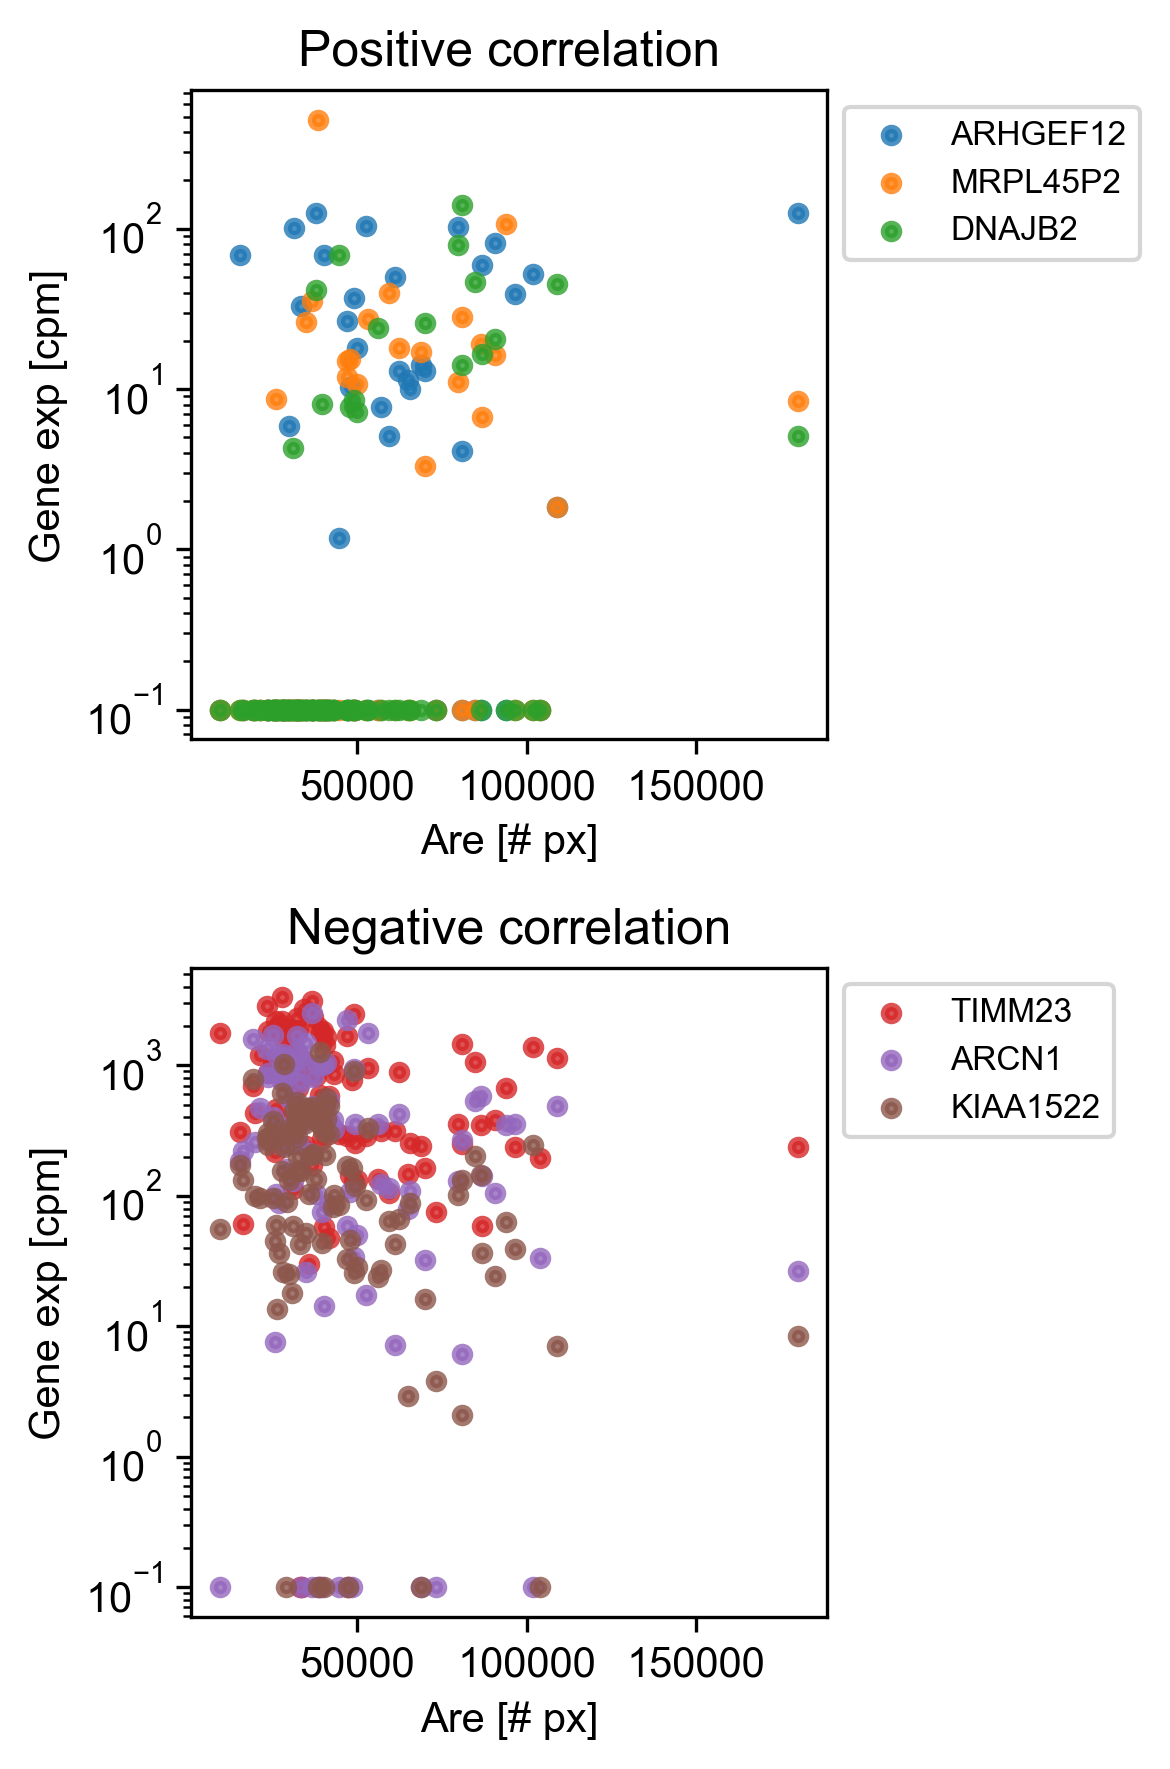

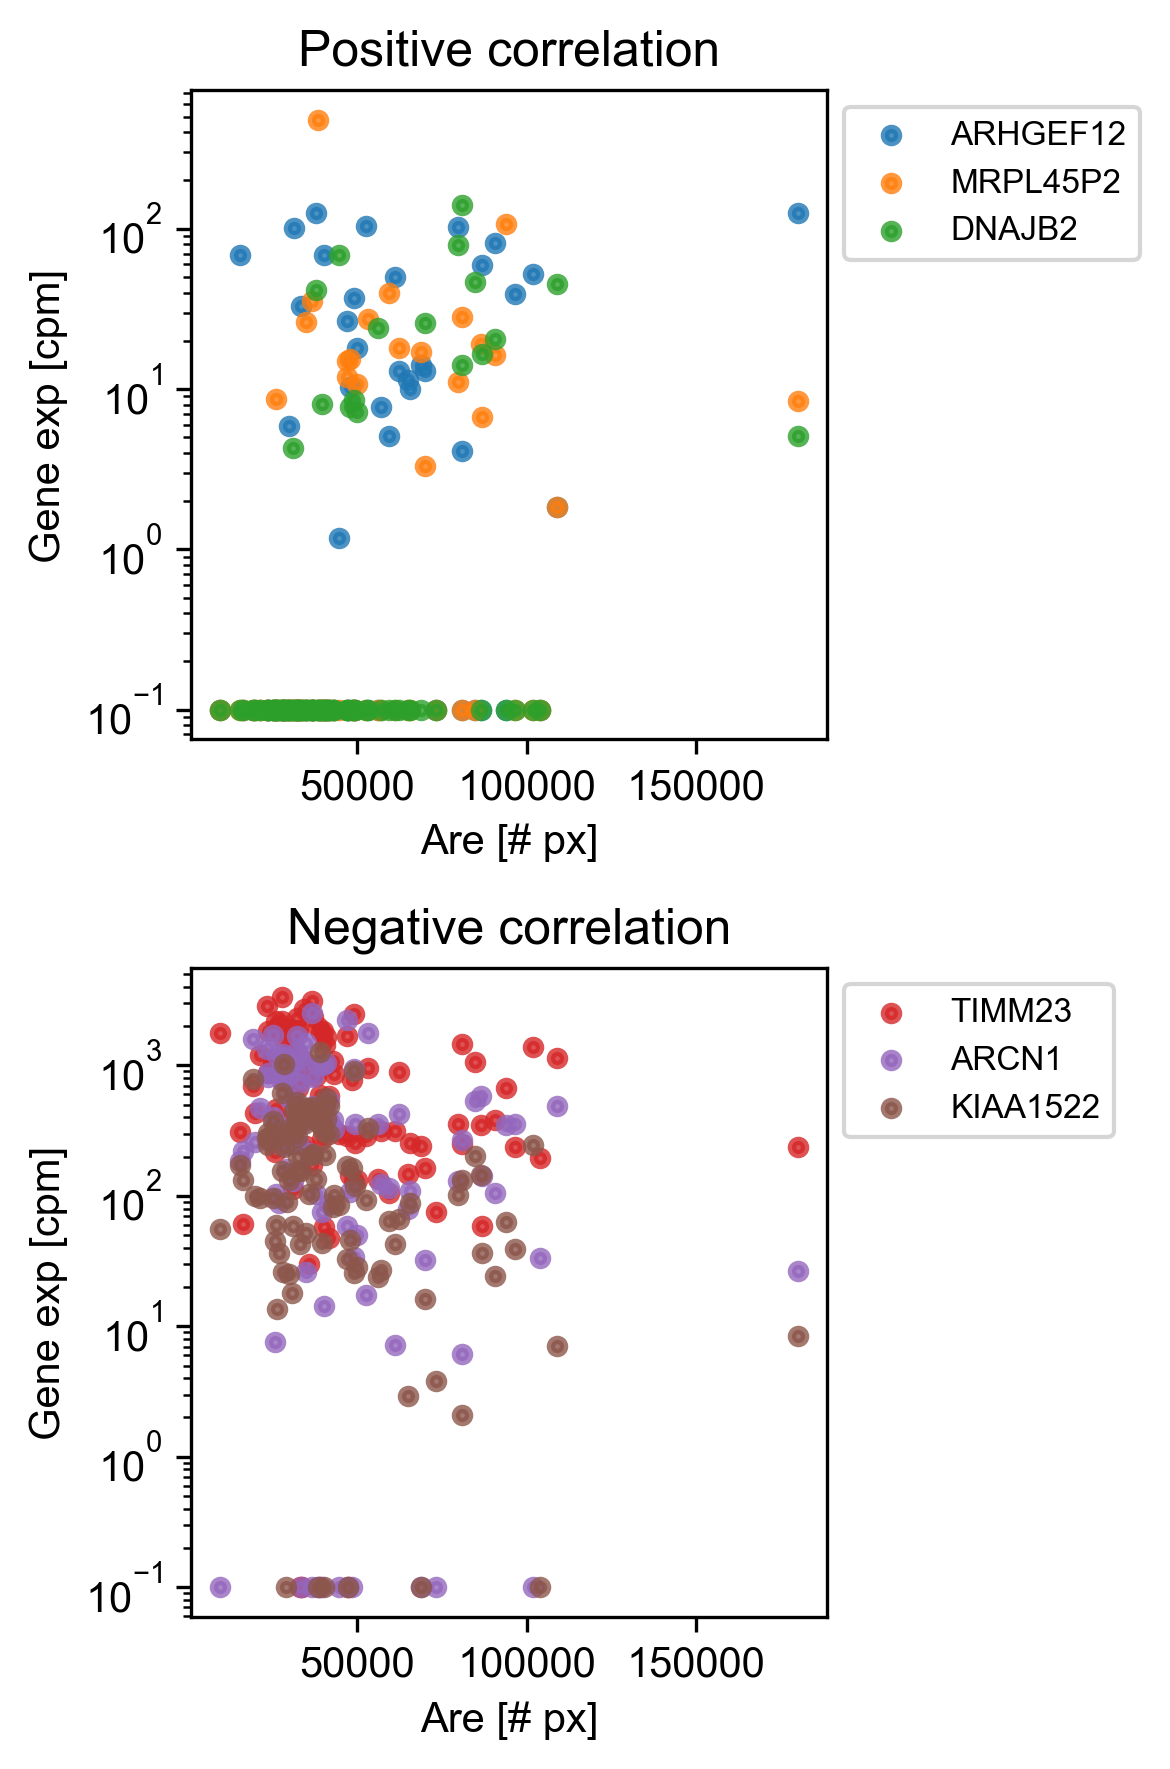

In [12]:
# feas = ['area', 'eccentricity', 'spectra_norm']
# xlabels = ['Area [px]', 'Eccentricity (y/x - 1)', 'Spectra/Area']

feas = ['area', ]
xlabels = ['Are [# px]']

for fea, xlabel in zip(feas, xlabels):

    path = save_figures
    filetype = '.png' 
    genes = {
        'positive': corr.nlargest(3, fea).index.tolist(),
        'negative': corr.nsmallest(3, fea).index.tolist(),
    }
    plot_correlation(genes, adata, fea, xlabel, path, filetype='.png')
    plot_correlation(genes, adata, fea, xlabel, path, filetype='.pdf')

### area

In [19]:
neg300 = corr['area'].fillna(0).sort_values()[:300].index.tolist()

In [20]:
pos300 = corr['area'].fillna(0).sort_values()[-300:].index.tolist()

In [21]:
import gseapy as gp
pos_res = gp.enrichr(gene_list=pos300,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
pos_res.res2d.to_csv(save_figures + 'GSEAPY_area_pos300.tsv', sep='\t')

from gseapy.plot import barplot, dotplot
barplot(pos_res.res2d,title='Pathways positively correlated with area', 
                   ofname=os.path.join(save_figures, 'GSEAPY_area_pos300' + '.svg')) 

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


In [22]:
import gseapy as gp
neg_res = gp.enrichr(gene_list=neg300,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
neg_res.res2d.to_csv(save_figures + 'GSEAPY_area_neg300.tsv', sep='\t')

from gseapy.plot import barplot, dotplot
barplot(neg_res.res2d,title='Pathways negatively correlated with area', 
                   ofname=os.path.join(save_figures, 'GSEAPY_area_neg300' + '.svg')) 

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


# eccentricity

In [23]:
neg300 = corr['eccentricity'].fillna(0).sort_values()[:300].index.tolist()

In [24]:
pos300 = corr['eccentricity'].fillna(0).sort_values()[-300:].index.tolist()

In [25]:
import gseapy as gp
pos_res = gp.enrichr(gene_list=pos300,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
pos_res.res2d.to_csv(save_figures + 'GSEAPY_eccentricity_pos300.tsv', sep='\t')

from gseapy.plot import barplot, dotplot
barplot(pos_res.res2d,title='Pathways positively correlated with area', 
                   ofname=os.path.join(save_figures, 'GSEAPY_eccentricity_pos300' + '.svg')) 

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-02-23 11:22:34,854 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


'Warning: No enrich terms using library Pathways positively correlated with area when cutoff = 0.05'

In [26]:
import gseapy as gp
neg_res = gp.enrichr(gene_list=neg300,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
neg_res.res2d.to_csv(save_figures + 'GSEAPY_eccentricity_neg300.tsv', sep='\t')

from gseapy.plot import barplot, dotplot
barplot(neg_res.res2d,title='Pathways negatively correlated with area', 
                   ofname=os.path.join(save_figures, 'GSEAPY_eccentricity_neg300' + '.svg')) 

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-02-23 11:22:40,914 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


'Warning: No enrich terms using library Pathways negatively correlated with area when cutoff = 0.05'